In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import jax


from emlp.reps import V,sparsify_basis,T
import emlp.groups as groups
import emlp
import jax.numpy as jnp
import numpy as np

/home/nmiklaucic/miniconda3/envs/avid/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
%cd ~/avid

/home/nmiklaucic/avid


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import rho_plus as rp
from emlp.reps.linear_operators import LazyPerm
from einops import rearrange

theme, cs = rp.mpl_setup(True)


plt.rcParams['image.cmap'] = 'viridis'
plt.rcParams['figure.dpi'] = 100


class SquarePerm(emlp.Group):
    def __init__(self, n: int, shift_subgroup: int = 1):
        assert n % shift_subgroup == 0

        base = jnp.arange(n * n).reshape(n, n)

        rots = []
        taus = []
        for ax in range(2):
            rots.append(jnp.flip(base, axis=ax))
            taus.append(jnp.roll(base, shift_subgroup, axis=ax))

        rots.append(jnp.flip(jnp.transpose(base), axis=0))
        rots.append(jnp.transpose(base))
        rots.append(jnp.flip(base, (0, 1)))

        perms = rearrange(jnp.array([rots + taus]), '1 b nx ny -> b (nx ny)')
        self.discrete_generators = [LazyPerm(perm) for perm in perms]
        super().__init__(n)

class CubicPerm(emlp.Group):
    def __init__(self, n: int, shift_subgroup: int = 1):
        assert n % shift_subgroup == 0

        base = jnp.arange(n * n * n).reshape(n, n, n)

        rots = []
        flips = []
        taus = []
        for ax in range(3):
            if ax > 0:
                axes = list(range(3))
                axes[0], axes[ax] = axes[ax], axes[0]
                rots.append(jnp.permute_dims(base, axes=axes))
            flips.append(jnp.flip(base, ax))
            taus.append(jnp.roll(base, shift_subgroup, axis=ax))

        perms = rearrange(jnp.array([rots + flips + taus]), '1 b nx ny nz -> b (nx ny nz)')
        self.discrete_generators = [LazyPerm(perm) for perm in perms]
        super().__init__(n)

Sq = SquarePerm
Cu = CubicPerm

In [6]:
B = (T(1) >> T(1))(Cu(5)).equivariant_basis()

Krylov Solving for Equivariant Subspace r<=20: 100%|██████████| 100/100 [00:00<00:00, 115.79it/s] 


[Duplicated Tetrahedral numbers](https://oeis.org/A058187)

In [7]:
def conv_basis(conv_size: int) -> np.ndarray:
    conv_basis = np.zeros((conv_size, conv_size, conv_size))
    n = ((conv_size + 2) // 2)
    i = 0
    for xyz in np.mgrid[0:n, 0:n, 0:n].reshape(3, -1).T:
        if not np.allclose(np.argsort(xyz), np.arange(3)):
            continue
        for s_xyz in np.mgrid[0:2, 0:2, 0:2].reshape(3, -1).T:
            # flip
            flip_xyz = xyz - 2 * xyz * s_xyz
            for perm in [[0, 1, 2], [0, 2, 1], [1, 0, 2], [1, 2, 0], [2, 0, 1], [2, 1, 0]]:
                # move -n - n into 0 - conv_size
                xi, yi, zi = flip_xyz[perm] + (n - 1)
                conv_basis[xi, yi, zi] = i
        i += 1
    return conv_basis

conv_basis(5)

array([[[9., 8., 5., 8., 9.],
        [8., 7., 4., 7., 8.],
        [5., 4., 2., 4., 5.],
        [8., 7., 4., 7., 8.],
        [9., 8., 5., 8., 9.]],

       [[8., 7., 4., 7., 8.],
        [7., 6., 3., 6., 7.],
        [4., 3., 1., 3., 4.],
        [7., 6., 3., 6., 7.],
        [8., 7., 4., 7., 8.]],

       [[5., 4., 2., 4., 5.],
        [4., 3., 1., 3., 4.],
        [2., 1., 0., 1., 2.],
        [4., 3., 1., 3., 4.],
        [5., 4., 2., 4., 5.]],

       [[8., 7., 4., 7., 8.],
        [7., 6., 3., 6., 7.],
        [4., 3., 1., 3., 4.],
        [7., 6., 3., 6., 7.],
        [8., 7., 4., 7., 8.]],

       [[9., 8., 5., 8., 9.],
        [8., 7., 4., 7., 8.],
        [5., 4., 2., 4., 5.],
        [8., 7., 4., 7., 8.],
        [9., 8., 5., 8., 9.]]])

In [8]:
np.mgrid[0:2, 0:2, 0:2].shape

(3, 2, 2, 2)

In [9]:
conv_basis(3)

array([[[3., 2., 3.],
        [2., 1., 2.],
        [3., 2., 3.]],

       [[2., 1., 2.],
        [1., 0., 1.],
        [2., 1., 2.]],

       [[3., 2., 3.],
        [2., 1., 2.],
        [3., 2., 3.]]])

[]

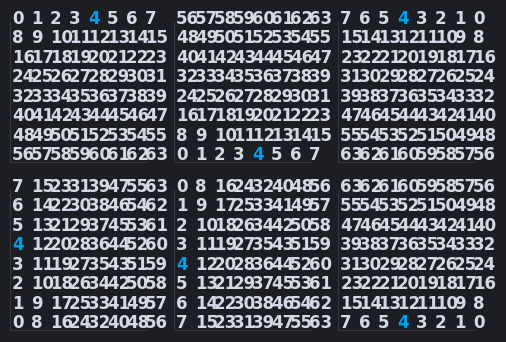

In [10]:
n = 8
nr = 2
nc = 3
fig, axs = plt.subplots(nr, nc, figsize=(nc * 2, nr * 2), sharex=True, sharey=True)
for dg, ax in zip([LazyPerm(np.arange(n ** 2))]  + Sq(n).discrete_generators, axs.flatten()):
    pos = dg.matvec(jnp.arange(n ** 2)).reshape(n, n)
    xx, yy = jnp.mgrid[0:n, 0:n]
    for x, y in zip(xx.reshape(-1), yy.reshape(-1)):
        t = pos[n - 1 - y, x]
        ax.text(x, y, t, color=cs[0] if t == 4 else '#' + theme['text.color'], fontdict={'weight': 'bold'})

ax.set_xlim(-.1, (n - 1) + .1)
ax.set_ylim(-.1, (n - 1) + .1)
ax.set_xticks([])
ax.set_yticks([])

In [ ]:
# https://oeis.org/A000217
# Square T(2)
#   n   4   5   6   7   8   9
#   #   6   6   10  10  15  15

# https://oeis.org/A000292
# Cube T(2)
#   n   4   5   6   7   8   9
#   #   10  10  20  20  35  35

# Square T(3)
#   n   2   3   4   5   6
#   #   10  15  55  91  210
# T(#)  4   5   10  13  20
# = T(S(n)), where S(n) = https://oeis.org/A236283

# Cube T(3)
#   n   2   3
#   #   20  35
# Te(#) 4   5
# = Te(S(n)), where S(n) = https://oeis.org/A236283

For choosing $k$ points in an $n \times n \times n$ cube, the first point can be fixed as the origin.

A236283 gives the number of triples from 1 to n under reflection and translation. This defines our fundamental region.

The remaining $k - 1$ points are chosen from the $p$ available positions up to that symmetry. This can be done, up to order, by the tetrahedral number of that point.

In [11]:
from math import comb
from itertools import product
import pandas as pd
def gen_elements(n, k, d):
    poly = jnp.array([n ** i for i in range(k - 1)], dtype=jnp.int32)
    pows = jnp.arange(k - 1, dtype=jnp.int32)[::-1]
    parity = 1 if n % 2 == 1 else 2
    coefs = jnp.dot(parity ** pows, poly)
    dom = ((n - parity) * coefs) // 2 + parity ** (k - 1)
    return comb(dom + (d - 1), d)

nn = jnp.arange(1, 10)
kk = jnp.arange(1, 5)
dd = jnp.array([2, 3])

df = []
for d, k, n in product(dd, kk, nn):
    df.append([n, k, d, gen_elements(n, k, d)])

df = pd.DataFrame(df, columns=['n', 'k', 'd', 'num'])

display(df.query('d == 2 and k > 1').T)
display(df.query('d == 3 and k > 1').T)

,9,10,11,12,13,14,15,16,17,18,...,26,27,28,29,30,31,32,33,34,35
n,1,2,3,4,5,6,7,8,9,1,...,9,1,2,3,4,5,6,7,8,9
k,2,2,2,2,2,2,2,2,2,3,...,3,4,4,4,4,4,4,4,4,4
d,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
num,1,3,3,6,6,10,10,15,15,1,...,861,1,36,105,666,2016,6328,14878,33930,66795


,45,46,47,48,49,50,51,52,53,54,...,62,63,64,65,66,67,68,69,70,71
n,1,2,3,4,5,6,7,8,9,1,...,9,1,2,3,4,5,6,7,8,9
k,2,2,2,2,2,2,2,2,2,3,...,3,4,4,4,4,4,4,4,4,4
d,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
num,1,4,4,10,10,20,20,35,35,1,...,12341,1,120,560,8436,43680,240464,862924,2963220,8171255


Krylov Solving for Equivariant Subspace r<=20: 100%|██████████| 100/100 [00:00<00:00, 110.06it/s] 


1.56e-04
[-197. -179. -144. -134. -105.  -75.  -62.  -60.  -53.  -26.   66.   67.
   79.  273.  338.]

(6561, 15)


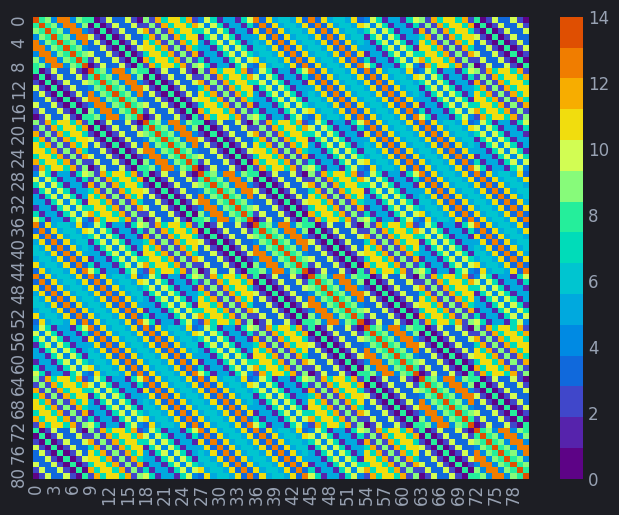

In [12]:
# Q = (T(1) >> T(1))(Sq(n)).equivariant_basis()
Q = (T(2))(Sq(n)).equivariant_basis()

def visualize(Q, shape):
    v = np.random.default_rng(127).standard_normal(Q.shape[0])
    v_proj = Q @ (Q.T @ v)
    eps = 1e-2
    uniq = []
    while len(uniq) != Q.shape[-1]:
        uniq, v = np.unique(np.rint(v_proj / eps), return_inverse=True)
        eps /= 2

    print(f'{eps:.2e}')
    print(uniq)
    print()
    v = v.reshape(shape)

    print(Q.shape)

    sns.heatmap(v, cmap=sns.color_palette('rho_spectra', Q.shape[-1]))
    return v_proj, v

v_proj, v = visualize(Q, (n ** 2, n ** 2))

In [13]:
M = v_proj.reshape(n ** 2, n ** 2)

x = np.random.default_rng(399).normal(1, 3, n ** 2)


for gen in Sq(n).discrete_generators:
    m1 = (M @ gen.matvec(x)).reshape(n, n)
    m2 = gen.matvec(M @ x).reshape(n, n)
    md = m1 - m2

    if np.max(np.abs(md)) > 1e-3:
        print(gen.perm.reshape(n, n))
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 3.5))
        sns.heatmap(m1, ax=ax1)
        sns.heatmap(m2, ax=ax2)
        sns.heatmap(md, ax=ax3)
    else:
        print(np.max(np.abs(md)))

0.00011950731
0.00014650822
0.0001167655
0.00017428398
0.0001155138
0.00018057227
0.00013136864


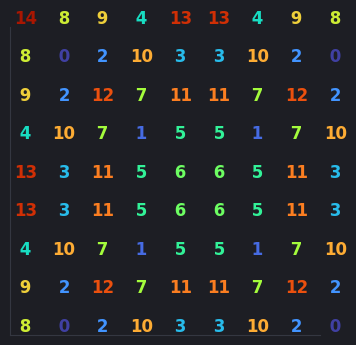

In [14]:
fig, ax = plt.subplots(figsize=(4, 4))
margin = 0.02


for comp, c in zip(range(Q.shape[-1]), sns.color_palette('turbo', Q.shape[-1])):
    for y1, x1, y2, x2 in zip(*np.nonzero((v == comp).reshape(n, n, n, n))):
        if (x1, y1) == (0, n - 1):
            plt.text(x2, y2, s=f'{comp:>2}', color=c, alpha=1, fontdict={'weight': 'bold'})
            # width = 0.005
            # head_width = 0.1
            # head_length = 1 * head_width
            # plt.arrow(x1, 3 - y1, (1 - margin) * (x2 - x1), (1 - margin) * -(y2 - y1), shape='full', length_includes_head=True, width=width, color=c, head_width=head_width, head_length=head_length)

# plt.legend()
ax.set_xlim(-0.1, (n - 1) - .1)
ax.set_ylim(-0.1, (n - 1) - .1)
ax.set_xticklabels([])
ax.set_yticklabels([]);

In [ ]:
n = 8
B = (T(1) >> T(1))(Cu(n)).equivariant_basis()
jnp.save(f'precomputed/equiv_basis_{n}.npy', np.array(B))

In [ ]:
class PatchPerm(emlp.Group):
    def __init__(self, n: int):
        base = jnp.arange(n * n * n).reshape(n, n, n)

        rots = []
        flips = []
        for ax in range(3):
            if ax > 0:
                axes = list(range(3))
                axes[0], axes[ax] = axes[ax], axes[0]
                rots.append(jnp.permute_dims(base, axes=axes))
            flips.append(jnp.flip(base, ax))

        perms = rearrange(jnp.array([rots + flips]), '1 b nx ny nz -> b (nx ny nz)')
        self.discrete_generators = [LazyPerm(perm) for perm in perms]
        super().__init__(n)

P3 = PatchPerm(3)

In [ ]:
b_p = (T(1) >> T(0))(P3).equivariant_basis()
visualize(b_p, (9, 3))

In [ ]:
kinds = np.array(
    [
        [[1, 2, 1], [2, 3, 2], [1, 2, 1]],
        [[2, 3, 2], [3, 0, 3], [2, 3, 2]],
        [[1, 2, 1], [2, 3, 2], [1, 2, 1]],
    ]
).reshape(-1)

basis = [kinds == k for k in range(max(kinds) + 1)]
basis = jnp.array(basis, dtype=jnp.bfloat16)

basis @ basis.T

In [ ]:
b_pt = (T(1) >> T(0))(Cu(3)).equivariant_basis()

visualize(b_pt, (9, 3))

In [ ]:
import jax.numpy as jnp
import numpy as np
import jax

In [ ]:
batch = 4
chan = 3
n = 8
dtype = jnp.bfloat16

x = jnp.array(np.random.randn(batch, chan, n ** 3) * 0.2, dtype=dtype)
x.mean()

In [ ]:
ijk = jnp.transpose(jnp.mgrid[0:n, 0:n, 0:n].astype(jnp.int16)).reshape(-1, 3)
sub = ijk[:, None, :] - ijk[None, :, :]
sub.shape

In [ ]:
idx = jnp.sort(jnp.minimum(jnp.abs(sub), n - jnp.abs(sub)), axis=-1)
orig = idx.shape

# uniq, inv = jnp.unique(idx.reshape(-1, 3), axis=0, return_inverse=True)
# print(uniq[:5, ...])
# print(uniq.shape)

dmax = (n) // 2
inv2 = (idx @ jnp.array([dmax ** 2, dmax, 1])).astype(jnp.int16)
inv2_i, inv2, counts = jnp.unique(inv2.reshape(-1), return_inverse=True, return_counts=True)
# jnp.allclose(inv2, inv)
print(inv2_i.shape)

In [ ]:
sns.heatmap(inv2.reshape(n, n, n, n, n, n)[0, 0, 0, 0, ...], cmap='rho_heatmap')

In [ ]:
from jax.experimental.sparse import sparsify, BCOO, BCSR

basis = jax.nn.one_hot(inv2, inv2_i.shape[0], dtype=jnp.bool_).reshape(*orig[:-1], inv2_i.shape[0])
# basis_sp = BCSR.fromdense(basis, n_batch=1)
basis_sp = basis
basis.shape

In [ ]:
from functools import partial
from einops import rearrange
from scipy.ndimage import convolve
from jax.experimental.sparse import sparsify
kernel = jnp.array(np.random.default_rng(123).normal(scale=0.2, size=inv2_i.shape[0]), dtype = jnp.bfloat16)
kernel = kernel / counts.astype(jnp.bfloat16)

v_and_g = partial(jax.value_and_grad, argnums=1)
@jax.jit
@sparsify
def f1(x, kernel, basis):
    return jnp.einsum('bcd,des,s->bce', x, basis, kernel, optimize='optimal')

@jax.jit
def f2(x, kernel, basis):
   conv = jnp.einsum('es,s->e', basis[0, :, :], kernel).reshape(1, 1, n, n, n)
   x = x.reshape(batch * chan, 1, n, n, n)
   x_tiled = jnp.tile(x, [1, 2, 2, 2])
   out = jax.lax.conv_general_dilated(
       x_tiled,
       conv,
       [1, 1, 1],
       padding='VALID',
       dimension_numbers=('NCDHW', 'OIDHW', 'NCDHW')
   )[:, :, :-1, :-1, :-1]
   return rearrange(out, '(batch chan) 1 n1 n2 n3 -> batch chan (n1 n2 n3)', batch=batch)

from flax.linen import Conv

layer = Conv(features=1, kernel_size=(n, n, n), use_bias=False, padding='CIRCULAR', dtype=jnp.bfloat16)


@jax.jit
def f3(x, kernel, basis):
   conv = jnp.einsum('es,s->e', basis[0, :, :], kernel).reshape(n, n, n, 1, 1)
   x = rearrange(x, 'batch chan (n1 n2 n3) -> (batch chan) n1 n2 n3 1', n1=n, n2=n, n3=n)
   out = layer.apply({'params': {'kernel': conv}}, x)
   return rearrange(out, '(batch chan) n1 n2 n3 1 -> batch chan (n1 n2 n3)', batch=batch)


res1 = f1(x, kernel, basis)
res2 = f2(x, kernel, basis)
res3 = f3(x, kernel, basis)

print(res1.shape, res2.shape, res3.shape, res1.mean(), res2.mean(), res3.mean())

In [ ]:
%%timeit

f1(x, kernel, basis).block_until_ready()

In [ ]:
%%timeit

f2(x, kernel, basis).block_until_ready()

In [ ]:
%%timeit

f3(x, kernel, basis).block_until_ready